# Optimal HDBSCAN* Leaves

This notebook demonstrates an alternative cluster selection strategy for
HDBSCAN* that efficiently optimizes the `min_cluster_size` parameter to find
maximally stable leaf-clusters.

## Preliminaries

The cells below load libraries, load data, and define functions for parts of the HDBSCAN* algorithm.

In [1]:
import numba
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from fast_hdbscan import HDBSCAN
from matplotlib.collections import LineCollection


sns.set(rc={"figure.figsize": (8, 8)})

In [2]:
data = np.load(
    BytesIO(
        requests.get(
            "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
        ).content
    )
)

In [3]:
from fast_hdbscan.cluster_trees import (
    get_cluster_label_vector,
    get_point_membership_strength_vector,
)
from fast_hdbscan.hdbscan import (
    compute_minimum_spanning_tree,
    mst_to_linkage_tree,
    mst_to_linkage_tree_w_sample_weights,
    condense_tree,
)


def hdbscan_cluster_hierarchy(data, min_samples, sample_weights=None):
    """Compute HDBSCAN* cluster hierarchy"""
    minimum_spanning_tree, _, _ = compute_minimum_spanning_tree(
        data, min_samples=min_samples
    )
    minimum_spanning_tree = minimum_spanning_tree[
        np.lexsort(
            (
                minimum_spanning_tree.T[1],
                minimum_spanning_tree.T[0],
                minimum_spanning_tree.T[2],
            )
        )
    ]
    if sample_weights is None:
        linkage_tree = mst_to_linkage_tree(minimum_spanning_tree)
    else:
        linkage_tree = mst_to_linkage_tree_w_sample_weights(
            minimum_spanning_tree, sample_weights
        )
    return condense_tree(
        linkage_tree, min_cluster_size=min_samples, sample_weights=sample_weights
    )


def hdbscan_segmentation(condensed_tree, selected_ids):
    """Compute HDBSCAN* labels and probabilities given the selected ids."""
    labels = get_cluster_label_vector(
        condensed_tree,
        selected_ids,
        cluster_selection_epsilon=0.0,
        n_samples=condensed_tree.parent[0],
    )
    probs = get_point_membership_strength_vector(condensed_tree, selected_ids, labels)
    return labels, probs

## HDBSCAN* cluster selection

HDBSCAN* simplifies single linkage dendrograms using a minimum cluster size to
create a cluster hierarchy (`condensed_tree`). The cluster hierarchy forms a
*merge-tree* listing which connected components exist over all density values.
As density decreases, larger distance edges enter the filtration and create
connections between connected components, merging them in the hierarchy. The
process describes the data's 0-dimensional topology in a filtration over the
density, effectively implementing a *persistent homology* computation.

Clusters are selected from the hierarchy using one of two selection strategies.
The *leaf* strategy always selects the cluster tree's leaves. These clusters
correspond to all local density maxima meeting the size threshold. Effectively,
**this strategy defines clusters as local density maxima**. In practice,
leaf-clusters depend strongly on the minimum cluster size value used to
construct the cluster hierarchy. Many small leaf clusters can be detected for
small minimum cluster sizes, resulting in segmentations where most points are
classified as noise. 

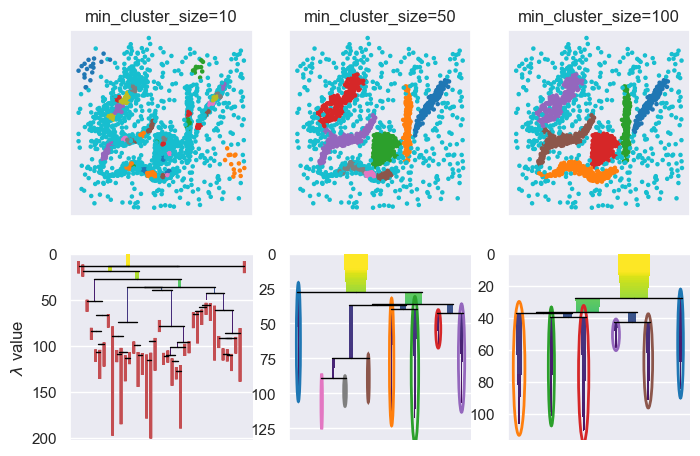

In [4]:
plt.figure(figsize=(8, 8 / 3 * 2))

kwargs = dict(s=5, cmap="tab10", vmax=9, vmin=0)
for i, size in enumerate([10, 50, 100]):
    c = HDBSCAN(
        min_samples=5, min_cluster_size=size, cluster_selection_method="leaf"
    ).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

The *EOM* strategy is more statistically motivated. It encourages fewer, larger
clusters by **defining clusters as a neighborhoods with an excess of probability
mass** (explained by Müller & Sawitzki, 1991). In statistical terms, the *EOM*
strategy interprets the density profile as a probability distribution and
computes its *modality*. Specifically, the strategy selects connected components
from the hierarchy that maximize a (relative) stability measure. The stability
measure aggregates the density-ranges in which points are part of a particular
connected component. It combines the number of points contained in the component
with the points' *persistence* in the density filtration. Selecting the most
persistent structures from a filtration as the *true* signal is common in
*persistent homology* and clustering (see, *cluster lifetime* referenced by
Campello et al., 2015). The stability adapts this notion to a cluster with
changing membership over density (Campello et al., 2015). While *EOM* clusters
are less sensitive to the minimum cluster size, they vary enough that the
parameter needs to be tuned to avoid small low-density clusters. Notice that
some clusters disappear at larger size thresholds.

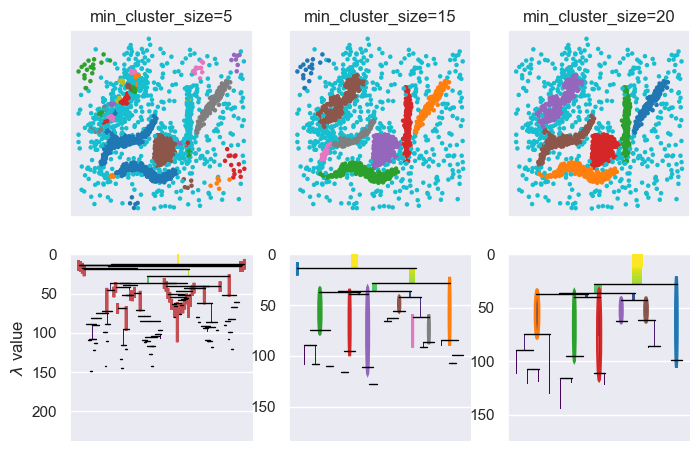

In [5]:
plt.figure(figsize=(8, 8 / 3 * 2))
for i, size in enumerate([5, 15, 20]):
    c = HDBSCAN(min_samples=5, min_cluster_size=size).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

Both selection strategies can select clusters with varying densities that do not
correspond to a straight density-cut in the cluster hierarchy. In other words,
there may not be a single distance or density value for which DBSCAN produces
the same clusters.

## Maximally stable leaf-clusters

The strategy proposed in this notebook combines the *leaf* and *EOM* strategies.
Where HDBSCAN* computes a cluster tree with all possible DBSCAN clusters, our
strategy creates a cluster tree with HDBSCAN* leaf-clusters over all possible
minimum cluster sizes. It then optimizes the `min_cluster_size` parameter to
find leaf-clusters with a maximal total stability. The result is **a
(practically) parameter free clustering algorithm that produces *EOM*-like
clusters** and a cluster hierarchy describing leaf-clusters at other size
thresholds.

The first step is to list the minimum cluster size range for which leaf-clusters
exist. This information can be extracted from HDBSCAN*'s cluster hierarchy
efficiently. The function below iterates over the `condensed_tree` (in
decreasing density order to ensure child-clusters are processed before their
parent-cluster). In each iteration a cluster-merge is processed. The sides'
minimum-cluster-size-deaths are recorded and their parent's birth is inferred.
The birth and death minimum cluster size ranges form a left-open interval
$(\text{birth}, \text{death}]$, with $\text{death} <= \text{birth}$ indicating
clusters that never become leaves on their own.

In [6]:
from fast_hdbscan.cluster_trees import mask_condensed_tree


@numba.njit()
def min_cluster_size_barcode(cluster_tree, n_points, min_size):
    """Lists cluster tree leaves with their birth and death minimum cluster sizes."""
    # Define output structures
    #   return leaf-cluster size interval (birth, death]
    #   support floating point sample_weight sizes
    n_nodes = cluster_tree.child[-1] - n_points + 1
    births = np.full(n_nodes, min_size, dtype=np.float32)
    deaths = np.full(n_nodes, min_size, dtype=np.float32)

    # Iterate over the tree in decreasing density order
    #   mergesort is stable so children are processed before their parents!
    #   right side id is one lower than the left side id
    #   right side occurs one row before the left side in the cluster tree
    order = np.argsort(cluster_tree.lambda_val, kind="mergesort")[::-1]
    for left_idx in order[0::2]:
        # record left and right death size
        out_idx = cluster_tree.child[left_idx] - n_points
        death_size = cluster_tree.child_size[left_idx - 1:left_idx + 1].min()
        deaths[out_idx - 1 : out_idx + 1] = death_size
        
        # record parent birth size
        births[cluster_tree.parent[left_idx] - n_points] = max(
            births[out_idx - 1], births[out_idx], death_size
        )

    # add root death at data set size
    deaths[0] = n_points
    return births, deaths

The procedure operates on HDBSCAN*'s cluster hierarchy `condensed_tree`:

In [7]:
# compute hdbscan condensed tree
min_samples = 5
n_points = data.shape[0]
condensed_tree = hdbscan_cluster_hierarchy(data, min_samples)

In [8]:
# extract leaf-cluster barcode from the condensed tree
mask = condensed_tree.child_size > 1
cluster_tree = mask_condensed_tree(condensed_tree, mask)
points_tree = mask_condensed_tree(condensed_tree, ~mask)
births, deaths = min_cluster_size_barcode(cluster_tree, n_points, min_samples)

The resulting birth and death values form a *barcode* that describes the
leaf-clusters' persistences in the minimum cluster size filtration:  

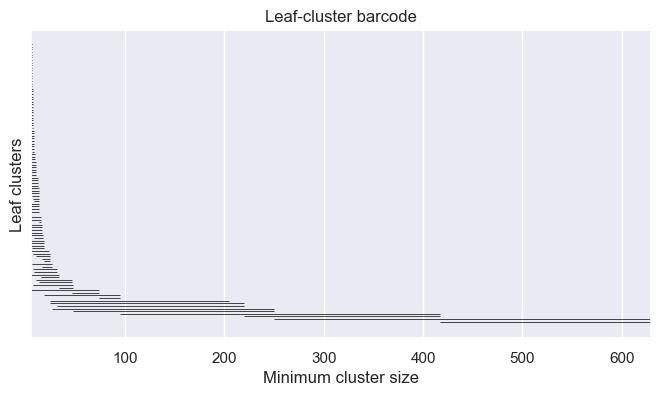

In [9]:
# Plot as a barcode
keep_mask = deaths > births
valid_births = births[keep_mask]
valid_deaths = deaths[keep_mask]
order = np.lexsort((-valid_births, -valid_deaths))
ranks = np.empty_like(order)
ranks[order] = np.arange(len(order))

plt.figure(figsize=(8, 4))
plt.gca().add_collection(
    LineCollection(
        np.column_stack((valid_births, ranks, valid_deaths, ranks)).reshape(-1, 2, 2),
        color="black",
        linewidth=0.5,
    )
)
plt.autoscale()
plt.xlim(min_samples, births[0])
plt.yticks([])
plt.title("Leaf-cluster barcode")
plt.xlabel("Minimum cluster size")
plt.ylabel("Leaf clusters")
plt.show()

### Count points in clusters

The second step finds an optimal minimum cluster size. As described above,
*EOM*'s stability measure combines the number of points in each cluster with
their *persistence* in that cluster. Consequently, the number of points in
clusters can be used as proxy for stability. 

The cell below computes the total number of points in clusters at each minimum
cluster size in the filtration. It considers only points that are part of a
leaf-cluster in its minimum cluster size life, as described in the barcode. The
result is an optimal minimum cluster size *for the minimum cluster size
filtration*.

In [10]:
@numba.njit()
def num_points_in_clusters(births, deaths):
    # maintain left-open (birth, death] interval!
    sizes = np.unique(births)
    clustered_points = np.zeros(sizes.shape[0], dtype=np.float32)
    for i, (birth, death) in enumerate(zip(births, deaths)):
        if death <= birth or i == 0:
            continue
        birth_idx, death_idx = np.searchsorted(sizes, [birth, death])
        clustered_points[birth_idx:death_idx] += death
    return sizes, clustered_points

The signal's global maximum indicates the optimal minimum cluster size
$\text{birth}$.

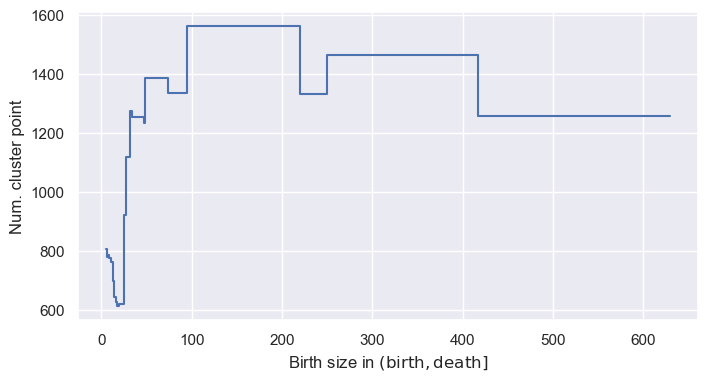

In [11]:
# list the number of points in each leaf birth and death
sizes, clustered_points = num_points_in_clusters(births, deaths)

# plot as previous interpolated curve
plt.figure(figsize=(8, 4))
plt.plot(
    np.column_stack((sizes[:-1], sizes[1:])).reshape(-1),
    np.repeat(clustered_points[:-1], 2)
)
plt.xlabel("Birth size in $(\\text{birth}, \\text{death}]$")
plt.ylabel("Num. cluster point")
plt.show()

This maximum occurs on the open-interval birth size, so the *next* size is the
actual optimal threshold to be used in HDBSCAN\*. Weighted samples make it
difficult to predict what that *next* value would be. We can still extract the
optimal leaf-clusters from the birth and death intervals, though!

In [12]:
# right-open conditions to apply left-open threshold to left-open intervals!
best_birth = sizes[np.argmax(clustered_points)]
selected_clusters = (
    np.where((births <= best_birth) & (deaths > best_birth))[0] + n_points
)

The optimal leaf-clusters from the minimum cluster size filtration have a
specific maximum size, i.e. their death size. There tend to be more points in
the cluster's local density maximum than that death size. Computing cluster
labels from the density cluster tree adds these points to the cluster. As a
result, the labelling can assign more points to a cluster than that
leaf-clusters death size. The result is an intricate combination of the minimum
cluster size and density filtrations.

*TODO: why does this strategy (appear to) work better than quantifying the
number of labelled points (i.e., all points up to the leaf-clusters'
density-deaths)?*

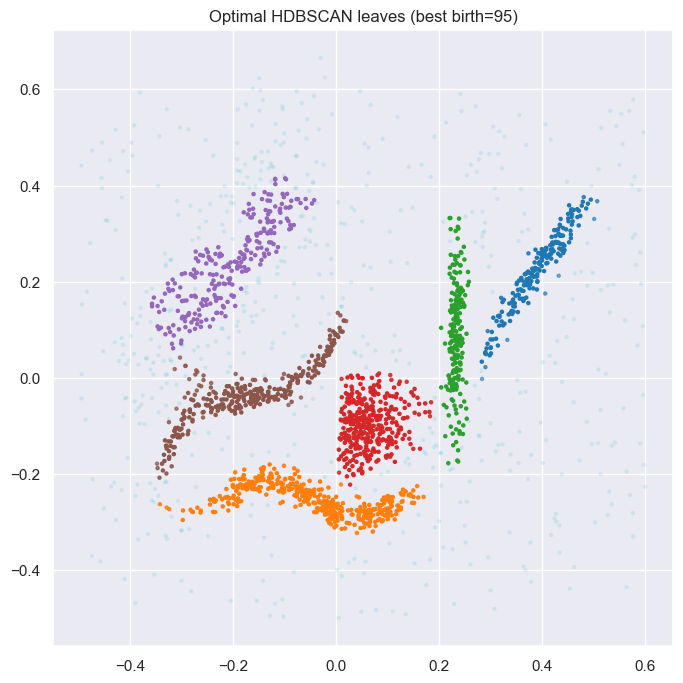

In [13]:
labels, probs = hdbscan_segmentation(condensed_tree, selected_clusters)

plt.scatter(*data.T, c=labels % 10, alpha=np.maximum(0.1, probs), **kwargs)
plt.title(f"Optimal HDBSCAN leaves (best birth={best_birth:.0f})")
plt.show()

Membership probabilities are computed on the original `condensed_tree`. The
resulting values do not match the probabilities that would be found with the
optimal minimum cluster size!

Just to check, the red cluster contains more points than its death size:

In [14]:
print(f"Red cluster:")
print(f"  num points assigned: {(labels == 3).sum()}")
print(f"  maximum size in filtration: {deaths[selected_clusters[3] - n_points]:.0f}")

Red cluster:
  num points assigned: 369
  maximum size in filtration: 220


### Compute stability

Optimizing the leaf-clusters' *stability* is more involved, but creates a more
statistically sound selection procedure. A cluster's stability is defined as the
sum of the cluster's points' persistences: 
$$ 
\text{stability} = \sum_i{\lambda^i_{\text{birth}} - \lambda_{\text{death}}}. 
$$
Here, $\lambda^i_{\text{birth}}$ is the density value at which a point $i$
enters a cluster and $\lambda_{\text{death}}$ is the density value at the
cluster's death size. As the minimum cluster size increases, the cluster's birth
density decreases. So, in practice, computing the stability has the form:
$$
\text{stability} = \text{min\_cluster\_size} * \lambda_{\text{birth}} +
\sum_i{\lambda^i_{\text{birth}} - \lambda_{\text{death}}} 
$$ 
where $\lambda_{\text{birth}}$ is the cluster's birth density at that minimum
cluster size and the sum only considers points that enter the cluster after its
birth. Just like in the number of clustered points signal, only the points up to
the minimum cluster size death are considered!

The cell below implements the computation for cases with and without weighted
samples. The resulting signals are on closed $[\text{birth}, \text{death}]$
intervals to ensure consistency regardless of sample weights.

In [15]:
from collections import namedtuple

# LeafInfo contains attributes used in the stability optimization:
#   min_size - all values in the closed [birth, death] interval
#   stability - stability values at the minimum cluster sizes
# and attributes used to compute membership probabilities:
#   child - data points joining the cluster after birth
#   lambda_vals - densities of child points
#   peak_points - data points in density peaks below minimum size
LeafInfo = namedtuple(
    "LeafInfo", ["min_size", "stability", "birth_lambda", "child", "peak_points"]
)

In [16]:
@numba.njit()
def _empty_leaf_info():
    """Empty leaf info structure."""
    return LeafInfo(
        np.empty(0, dtype=np.float32),
        np.empty(0, dtype=np.float32),
        np.empty(0, dtype=np.float32),
        np.empty(0, dtype=np.int64),
        np.empty(0, dtype=np.int64),
    )


@numba.njit()
def _to_directed_cluster_graph(cluster_tree):
    """Converts the cluster tree to sparse directed graph."""
    return {
        cluster_tree.parent[i]: (cluster_tree.child[i], cluster_tree.child[i + 1])
        for i in range(0, len(cluster_tree.parent), 2)
    }


@numba.njit()
def _list_child_clusters(directed_tree, segment_id):
    """Extracts cluster segments below the segment_id segment."""
    result = set([np.int64(0) for _ in range(0)])
    to_process = [segment_id]

    while len(to_process) > 0:
        result.update(to_process)
        next_process = [np.int64(0) for _ in range(0)]
        for i in to_process:
            if i not in directed_tree:
                continue
            next_process.extend(directed_tree[i])
        to_process = next_process
    return result


@numba.njit()
def _extract_points(points_tree, segment_ids):
    """Extracts all points with a segment id in segment_ids as parent."""
    mask = np.zeros(points_tree.parent.shape[0], dtype=np.bool_)
    for idx, parent in enumerate(points_tree.parent):
        if parent in segment_ids:
            mask[idx] = True
    return mask_condensed_tree(points_tree, mask)


@numba.njit()
def _extract_traversal_trees(cluster_tree, points_tree):
    """ "Repeated code pattern to extract cluster & points trees."""
    directed_cluster_tree = _to_directed_cluster_graph(cluster_tree)
    points_tree = mask_condensed_tree(
        points_tree, np.argsort(points_tree.lambda_val)[::-1]
    )
    return directed_cluster_tree, points_tree


@numba.njit()
def compute_leaf_infos_w_sample_weights(cluster_tree, points_tree, births, deaths):
    """Compute the stability for cluster leaves with weighted samples."""
    # create traversal structures
    n_points = cluster_tree.parent[0]
    directed_cluster_tree, points_tree = _extract_traversal_trees(
        cluster_tree, points_tree
    )

    # define output structure
    leaf_infos = [_empty_leaf_info() for _ in range(0)]

    # iterate over the leaves
    for i, (min_size, max_size) in enumerate(zip(births, deaths)):
        # empty arrays for non-leaves
        if max_size <= min_size:
            leaf_infos.append(_empty_leaf_info())
            continue

        # extract all points in the condensed tree segments
        leaf_id = i + n_points
        if leaf_id == n_points:
            segment_points = points_tree
        else:
            segment_ids = _list_child_clusters(directed_cluster_tree, leaf_id)
            segment_points = _extract_points(points_tree, segment_ids)

        # extract points within the leaf-cluster
        birth_sizes = np.cumsum(segment_points.child_size)
        lower_idx, upper_idx = np.searchsorted(
            birth_sizes, [min_size, max_size], side="right"
        )
        min_size = birth_sizes[lower_idx:upper_idx]
        birth_lambda = segment_points.lambda_val[lower_idx:upper_idx]
        sample_weight = segment_points.child_size[lower_idx:upper_idx]
        child = segment_points.child[lower_idx:]

        # find the death-size density (one past death size)
        if segment_points.lambda_val.shape[0] > upper_idx:
            death_lambda = segment_points.lambda_val[upper_idx]
        else:
            death_lambda = cluster_tree.lambda_val[
                np.searchsorted(cluster_tree.child, leaf_id)
            ]

        # compute the stability curve
        persistences = birth_lambda - death_lambda
        stability = min_size * persistences
        stability[:-1] += (sample_weight * persistences)[::-1].cumsum()[::-1][1:]

        # store both the sizes and the stability
        peak_points = segment_points.child[:lower_idx]
        leaf_infos.append(
            LeafInfo(min_size, stability, birth_lambda, child, peak_points)
        )

    return leaf_infos

In [17]:
@numba.njit()
def compute_leaf_infos(cluster_tree, points_tree, births, deaths):
    """Compute the stability for cluster leaves without weighted samples."""
    # create traversal structures (sorts points_tree by density!)
    n_points = cluster_tree.parent[0]
    directed_cluster_tree, points_tree = _extract_traversal_trees(
        cluster_tree, points_tree
    )

    # define output structure
    leaf_infos = [_empty_leaf_info() for _ in range(0)]

    # iterate over the leaves
    for i, (min_size, max_size) in enumerate(zip(births, deaths)):
        # empty arrays for non-leaves
        if max_size <= min_size:
            leaf_infos.append(_empty_leaf_info())
            continue

        # extract all points in the leaf-cluster
        leaf_id = i + n_points
        if leaf_id == n_points:
            segment_points = points_tree
        else:
            segment_ids = _list_child_clusters(directed_cluster_tree, leaf_id)
            segment_points = _extract_points(points_tree, segment_ids)

        # extract points within the leaf-cluster lifetime
        lower_idx, upper_idx = np.int32(min_size), np.int32(max_size)
        min_sizes = np.arange(min_size + 1, max_size + 1, dtype=np.float32)
        birth_lambda = segment_points.lambda_val[lower_idx:]
        child = segment_points.child[lower_idx:]

        # find the death-size density (one past death size)
        if segment_points.lambda_val.shape[0] > upper_idx:
            death_lambda = segment_points.lambda_val[upper_idx]
        else:
            death_lambda = cluster_tree.lambda_val[
                np.searchsorted(cluster_tree.child, leaf_id)
            ]

        # compute the stability curve
        persistences = birth_lambda[: upper_idx - lower_idx] - death_lambda
        stability = min_sizes * persistences
        stability[:-1] += persistences[::-1].cumsum()[::-1][1:]

        # store the computed information
        peak_points = segment_points.child[:lower_idx]
        leaf_infos.append(
            LeafInfo(min_sizes, stability, birth_lambda, child, peak_points)
        )

    return leaf_infos

The computed stabilities list the leaf-clusters' stabilities at all sizes they
exist. It can be visualized by coloring the barcode with the stability values:

In [18]:
leaf_infos = compute_leaf_infos(cluster_tree, points_tree, births, deaths)

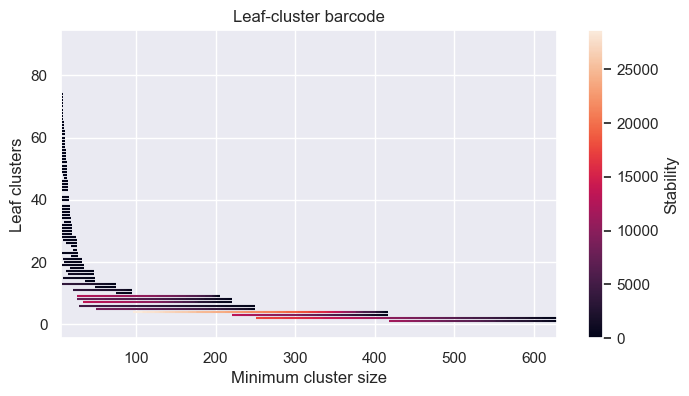

In [19]:
plt.figure(figsize=(8, 4))
count = 0
max_stability = max(
    leaf_info.stability.max()
    for leaf_info in leaf_infos[1:]
    if leaf_info.min_size.size > 0
)
for leaf_info in leaf_infos:
    if leaf_info.min_size.size == 0:
        continue
    rank = ranks[count]
    count += 1
    n_segments = leaf_info.min_size.size - 1
    lc = LineCollection(
        np.column_stack(
            (
                leaf_info.min_size[:-1],
                np.repeat(rank, n_segments),
                leaf_info.min_size[1:],
                np.repeat(rank, n_segments),
            )
        ).reshape(-1, 2, 2),
        clim=(0, max_stability),
    )
    lc.set_array(leaf_info.stability)
    plt.gca().add_collection(lc)
plt.autoscale()
plt.xlim(min_samples, births[0])
plt.title("Leaf-cluster barcode")
plt.xlabel("Minimum cluster size")
plt.ylabel("Leaf clusters")
plt.colorbar(lc, label="Stability")
plt.show()

Like the number of clustered points quality measure, the cluster stability
curves can be summed to create a total stability value per minimum cluster size.
When samples weights are provided, this process becomes more complicated and
involves a previous-value interpolation onto the detected unique clusters sizes.
Both cases keep the signals on closed $[\text{birth}, \text{death}]$ intervals,
so the maxima can be used as `min_cluster_size` parameter values.

In [20]:
@numba.njit()
def compute_total_stability(births, leaf_infos, min_size):
    """Compute the total stability per minimum cluster size."""
    sizes = np.arange(min_size, births[0] + 1, dtype=np.float32)
    total_stability = np.zeros(sizes.shape[0], dtype=np.float32)

    # Skip root cluster's signal
    for info in leaf_infos[1:]:
        leaf_sizes = info.min_size
        if leaf_sizes.shape[0] == 0:
            continue
        lower_idx = np.int32(leaf_sizes[0] - min_size)
        upper_idx = np.int32(leaf_sizes[-1] - min_size)
        total_stability[lower_idx:upper_idx] += info.stability
    return sizes, total_stability

In [21]:
@numba.njit(
    locals={
        "birth_idx": numba.int64,
        "death_idx": numba.int64,
        "leaf_idx": numba.int64,
        "tot_idx": numba.int64,
    }
)
def compute_total_stability_w_sample_weights(births, leaf_infos):
    """Compute the total stability per minimum cluster size with weighted
    samples."""
    # find all size values
    sizes = np.unique(births)
    for info in leaf_infos[1:]:
        sizes = np.union1d(sizes, info.min_size)
    total_stability = np.zeros(sizes.shape[0], dtype=np.float32)

    # Skip root cluster's signal
    for info in leaf_infos[1:]:
        leaf_sizes = info.min_size
        if leaf_sizes.shape[0] == 0:
            continue
        # find the output indices to fill
        birth_idx, death_idx = np.searchsorted(sizes, [leaf_sizes[0], leaf_sizes[-1]])

        # previous interpolation onto the output size array
        leaf_idx = 0
        for tot_idx in range(birth_idx, death_idx):
            while sizes[tot_idx] > leaf_sizes[leaf_idx]:
                leaf_idx += 1
            total_stability[tot_idx] += info.stability[leaf_idx]

    return sizes, total_stability

Effectively, the total stability sums all leaf-cluster stability values on
vertical lines through the barcode:

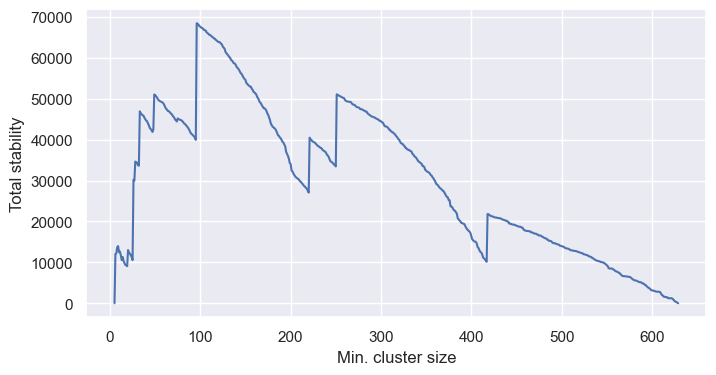

In [22]:
sizes, total_stability = compute_total_stability(births, leaf_infos, min_samples)

plt.figure(figsize=(8, 4))
plt.plot(sizes, total_stability)
plt.xlabel("Min. cluster size")
plt.ylabel("Total stability")
plt.show()

The collected leaf-cluster information contains enough information compute a
cluster assignment with more accurate membership probabilities for an arbitrary
minimum cluster size:

In [23]:
@numba.njit()
def clustering_at_cut(leaf_infos, best_size):
    count = 0
    probs = np.zeros(n_points, dtype=np.float32)
    labels = np.full(n_points, -1, dtype=np.int64)
    for info in leaf_infos[1:]:
        leaf_sizes = info.min_size
        if (
            leaf_sizes.shape[0] == 0
            or leaf_sizes[0] > best_size
            or leaf_sizes[-1] < best_size
        ):
            continue

        # find the density at the best size
        lambda_idx = np.searchsorted(leaf_sizes, best_size, side="right")
        best_lambda = info.birth_lambda[lambda_idx]

        # label points that enter the cluster above its minimum size
        labels[info.child] = count
        probs[info.child] = np.minimum(info.birth_lambda / best_lambda, 1.0)

        # label points that enter the cluster before its minimum size
        labels[info.peak_points] = count
        probs[info.peak_points] = 1.0
        count += 1

    return labels, probs

Maximizing leaf-cluster stability finds a similar segmentation with more larger
membership probability differences:

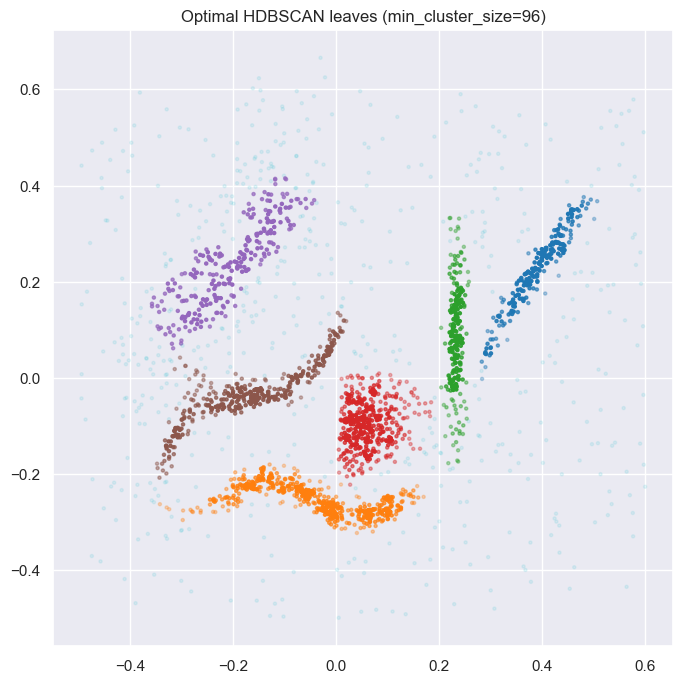

In [24]:
# find best minimum cluster size
best_size = sizes[np.argmax(total_stability)]
labels, probs = clustering_at_cut(leaf_infos, best_size)

plt.scatter(*data.T, c=labels % 10, alpha=np.maximum(probs, 0.1), **kwargs)
plt.title(f"Optimal HDBSCAN leaves (min_cluster_size={best_size:.0f})")
plt.show()

### Plotting leaf-cluster as tree

The leaf-clusters can also be plotted as a tree with matplotlib's `pcolormesh`.
Icicle widths indicate the cluster's stability at that minimum cluster size.
Icicle color indicates the total stability over all clusters at that minimum
cluster size.

In [25]:
import warnings
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap


def find_leaf_cluster_parents(condensed_tree, leaf_infos):
    """Finds first condensed tree ancestor that is a leaf-cluster"""
    parents = {}
    root = condensed_tree["parent"][0]
    cluster_tree = condensed_tree[condensed_tree["child_size"] > 1]
    for i in range(1, len(leaf_infos)):
        if leaf_infos[i].min_size.shape[0] == 0:
            continue
        current = i
        while current == i or leaf_infos[current].min_size.shape[0] == 0:
            idx = np.searchsorted(cluster_tree["child"], current + root)
            current = cluster_tree["parent"][idx] - root
        parents[i] = current
    return parents


def compute_x_coords(parents):
    """Compute x-coordinates for the leaf clusters."""
    # Convert to directed graph
    children = dict()
    for leaf_idx, parent in parents.items():
        if parent not in children:
            children[parent] = []
        children[parent].append(leaf_idx)

    # List x-coordinates
    return {leaf: i for i, leaf in enumerate(df_leaf_order(children, 0))}


def df_leaf_order(children, idx):
    """Depth-first traversal to order the leaf clusters."""
    order = [idx]
    if idx in children:
        for child in children[idx][::-1]:
            order += df_leaf_order(children, child)
    return order


class LeafClusterTree:
    def __init__(
        self, labels, condensed_tree, leaf_infos, stability_sizes, stability_values
    ):
        self.labels = labels
        self.leaf_infos = leaf_infos
        self.condensed_tree = condensed_tree
        self.parents = find_leaf_cluster_parents(condensed_tree, leaf_infos)
        self.stability_sizes = stability_sizes
        self.stability_values = stability_values
        self.max_stability = leaf_infos[0].stability[0]
        self.max_total_stability = stability_values.max()

    def as_pandas(self):
        import pandas as pd

        return pd.DataFrame(
            dict(
                birth=[
                    leaf_info.min_size[0]
                    for leaf_info in self.leaf_infos
                    if leaf_info.min_size.shape[0] > 0
                ],
                death=[
                    leaf_info.min_size[-1]
                    for leaf_info in self.leaf_infos
                    if leaf_info.min_size.shape[0] > 0
                ],
                parent=[
                    self.parents.get(i, None)
                    for i in range(len(leaf_infos))
                    if leaf_infos[i].min_size.shape[0] > 0
                ],
            )
        )

    def _select_clusters(self):
        mask = self.condensed_tree["child_size"] > 1
        cluster_tree = self.condensed_tree[mask]
        points_tree = self.condensed_tree[~mask]

        # find lowest cluster segment id for each cluster label
        segments = points_tree["parent"]
        labels = self.labels[points_tree["child"]]
        order = np.argsort(labels)
        groups = np.split(
            segments[order], np.flatnonzero(np.diff(labels[order]) != 0) + 1
        )
        selected_clusters = [
            groups[label].min()
            for label in range(int(labels[order[0]] == -1), len(groups))
        ]

        # find first condensed tree ancestor that is a leaf-cluster
        root = cluster_tree["parent"][0]
        for label, leaf_id in enumerate(selected_clusters):
            while self.leaf_infos[leaf_id - root].min_size.shape[0] == 0:
                leaf_id = cluster_tree["parent"][
                    np.searchsorted(cluster_tree["child"], leaf_id)
                ]
            selected_clusters[label] = leaf_id

        return selected_clusters

    def plot(
        self,
        inf_padding=0.1,
        min_width=0.05,
        max_width=3,
        cmap="viridis",
        colorbar=True,
        colorbar_kws=None,
        death_line_kws=None,
        connect_line_kws=None,
        indicator_radius=30,
        indicator_offset=8,
        selection_palette=None,
    ):
        if colorbar_kws is None:
            colorbar_kws = dict()
        max_width = (max_width - min_width) / 2
        max_birth = self.leaf_infos[0].min_size[0]
        inf_value = round((1 + inf_padding) * max_birth)
        x_coords = compute_x_coords(self.parents)

        # vertical lines connecting death of leaf cluster to birth of parent cluster
        _death_line_kws = dict(linestyle=":", color="black", linewidth=0.5)
        if death_line_kws is not None:
            _death_line_kws.update(death_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_idx], self.leaf_infos[leaf_idx].min_size[-1]),
                        (x_coords[leaf_idx], self.leaf_infos[parent_idx].min_size[0]),
                    ]
                    for leaf_idx, parent_idx in self.parents.items()
                ],
                **_death_line_kws
            )
        )

        # horizontal lines connecting leaf cluster to its parent cluster
        _connect_line_kws = dict(linestyle="-", color="black", linewidth=0.5)
        if connect_line_kws is not None:
            _connect_line_kws.update(connect_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_idx], self.leaf_infos[parent_idx].min_size[0]),
                        (x_coords[parent_idx], self.leaf_infos[parent_idx].min_size[0]),
                    ]
                    for leaf_idx, parent_idx in self.parents.items()
                ],
                **_connect_line_kws
            )
        )

        # draw an icicle for each leaf cluster
        for i, leaf in enumerate(self.leaf_infos):
            if leaf.min_size.shape[0] == 0:
                continue
            
            # the stability signal
            sizes = leaf.min_size
            stability = leaf.stability

            # icicle widths
            xs = x_coords[i] + np.asarray([[-min_width / 2], [min_width / 2]])
            widths = xs + stability / self.max_stability * max_width * np.array(
                [[-1], [1]]
            )
            
            # icicle colors
            if i == 0:
                total_stability = np.zeros_like(self.leaf_infos[0].stability)
            else:
                total_stability = self.stability_values[np.isin(self.stability_sizes, sizes)]

            # plot the icicle
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                bar = plt.pcolormesh(
                    widths,
                    np.broadcast_to(sizes, (2, len(sizes))),
                    np.broadcast_to(total_stability, (2, len(sizes))),
                    vmin=0,
                    vmax=self.max_total_stability,
                    edgecolors="none",
                    linewidth=0,
                    cmap=cmap,
                )

        # coloured circle for each selected cluster
        if indicator_radius > 0:
            if selection_palette is None:
                selection_palette = plt.cm.tab10.colors
            leaf_labeling = self._select_clusters() - self.condensed_tree["parent"][0]
            leaf_labels, leaf_xs, leaf_births = zip(
                *[
                    (
                        label % len(selection_palette),
                        x_coords[leaf_id],
                        self.leaf_infos[leaf_id].min_size[0] - indicator_offset,
                    )
                    for label, leaf_id in enumerate(leaf_labeling)
                ]
            )
            plt.scatter(
                leaf_xs,
                leaf_births,
                s=indicator_radius,
                c=leaf_labels,
                cmap=ListedColormap(selection_palette),
                vmin=0,
                vmax=len(selection_palette) - 1,
                zorder=10,
            )

        if colorbar:
            if "fraction" in colorbar_kws:
                bbox = plt.gca().get_window_extent()
                ax_width, ax_height = bbox.width, bbox.height
                colorbar_kws["aspect"] = ax_height / (
                    ax_width * colorbar_kws["fraction"]
                )
            plt.colorbar(bar, label="Total stability", **colorbar_kws)

        plt.xticks([])
        plt.ylabel("Min. cluster size")
        xlim = plt.xlim()
        plt.xlim([xlim[0] - 0.02 * xlim[1], 1.02 * xlim[1]])
        plt.ylim([0, inf_value])

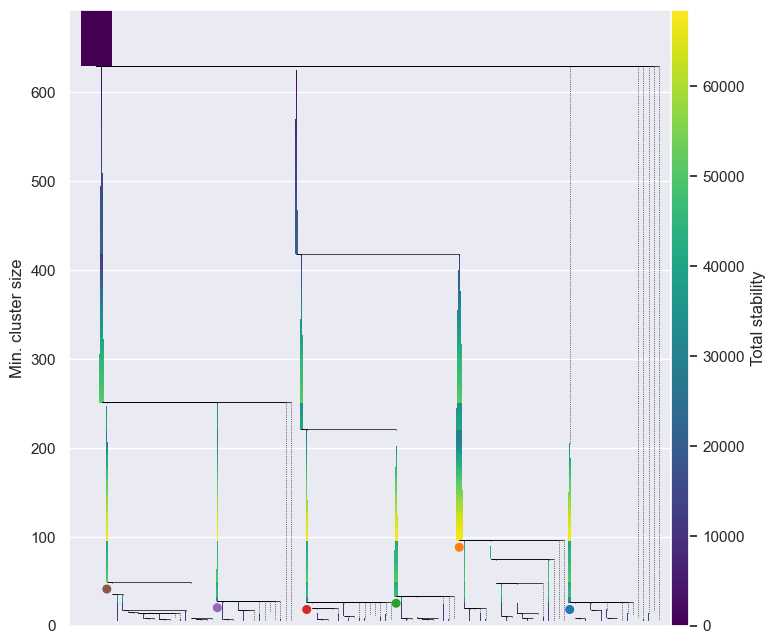

In [26]:
from fast_hdbscan.hdbscan import to_numpy_rec_array

plot_tree = to_numpy_rec_array(condensed_tree)

plt.figure()
tree_class = LeafClusterTree(labels, plot_tree, leaf_infos, sizes, total_stability)
tree_class.plot(colorbar_kws=dict(pad=0, fraction=0.03))
plt.show()

### Parameter sensitivity

When counting the distance metric as input, only the `min_samples`
parameter remains. This parameter smooths the computed density profile which
prunes low stability leaves from the the leaf-cluster tree. **Changing
`min_samples`** changes the optimal minimum cluster size, but **does not really
change which clusters are selected**. As demonstrated above, this is not true
for the other cluster selection strategies and the minimum cluster size
parameter! At higher `min_samples` the selected clusters becomes smaller, with
more points classified as noise. This suggests low `min_samples` values work
better. However, at too low values (i.e. `min_samples=2` below), the resulting
clusters might to sensitive to local density changes.

*TODO: why does optimizing the stability computed for leaf-clusters with points
up to their density-death, rather than the minimum-size-death, not have this
property (on this data set)?*

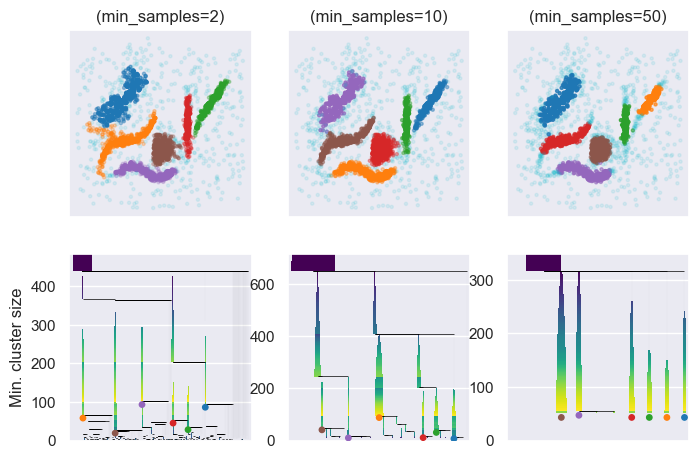

In [27]:
plt.figure(figsize=(8, 8 / 3 * 2))

max_widths = [25, 5, 1]
for i, size in enumerate([2, 10, 50]):
    # Compute initial condensed tree
    minimum_spanning_tree, _, _ = compute_minimum_spanning_tree(data, min_samples=size)
    sorted_mst = minimum_spanning_tree[
        np.lexsort(
            (
                minimum_spanning_tree.T[1],
                minimum_spanning_tree.T[0],
                minimum_spanning_tree.T[2],
            )
        )
    ]
    linkage_tree = mst_to_linkage_tree(sorted_mst)
    condensed_tree = condense_tree(linkage_tree, min_cluster_size=size)

    # Compute optimal leaf-clustering
    mask = condensed_tree.child_size > 1
    cluster_tree = mask_condensed_tree(condensed_tree, mask)
    points_tree = mask_condensed_tree(condensed_tree, ~mask)
    births, deaths = min_cluster_size_barcode(cluster_tree, n_points, size)
    leaf_infos = compute_leaf_infos(cluster_tree, points_tree, births, deaths)
    sizes, total_stability = compute_total_stability(births, leaf_infos, size)
    best_size = sizes[np.argmax(total_stability)]
    labels, probs = clustering_at_cut(leaf_infos, best_size)

    plt.subplot(2, 3, i + 1)
    plt.scatter(*data.T, c=labels % 10, alpha=np.maximum(probs, 0.1), **kwargs)
    plt.title(f"(min_samples={size})")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    plot_tree = to_numpy_rec_array(condensed_tree)
    tree_class = LeafClusterTree(labels, plot_tree, leaf_infos, sizes, total_stability)
    tree_class.plot(
        colorbar=False,
        max_width=max_widths[i],
        indicator_radius=15,
        death_line_kws=dict(linewidth=0.1, alpha=0.3),
    )
    if i > 0:
        plt.ylabel("")
plt.show()

### Compute cost

The cells below measure compute cost for the cluster selection strategies. All
strategies take the condensed tree as input and give labels and probabilities as
output.

In [ ]:
from fast_hdbscan.cluster_trees import (
    extract_leaves,
    extract_eom_clusters,
    cluster_tree_from_condensed_tree,
)


@numba.njit()
def time_eom(condensed_tree, _):
    cluster_tree = mask_condensed_tree(condensed_tree, condensed_tree.child_size > 1)
    selected = extract_eom_clusters(condensed_tree, cluster_tree)
    labels = get_cluster_label_vector(
        condensed_tree,
        selected,
        cluster_selection_epsilon=0.0,
        n_samples=condensed_tree.parent[0],
    )
    probs = get_point_membership_strength_vector(condensed_tree, selected, labels)
    return labels, probs


@numba.njit()
def time_leaves(condensed_tree, _):
    selected = extract_leaves(cluster_tree)
    labels = get_cluster_label_vector(
        condensed_tree,
        selected,
        cluster_selection_epsilon=0.0,
        n_samples=condensed_tree.parent[0],
    )
    probs = get_point_membership_strength_vector(condensed_tree, selected, labels)
    return labels, probs


@numba.njit()
def time_stability_leaves(condensed_tree, min_samples):
    mask = condensed_tree.child_size > 1
    cluster_tree = mask_condensed_tree(condensed_tree, mask)
    points_tree = mask_condensed_tree(condensed_tree, ~mask)

    births, deaths = min_cluster_size_barcode(cluster_tree, n_points, min_samples)
    leaf_infos = compute_leaf_infos(cluster_tree, points_tree, births, deaths)
    sizes, total_stability = compute_total_stability(births, leaf_infos, min_samples)
    best_size = sizes[np.argmax(total_stability)]
    return clustering_at_cut(leaf_infos, best_size)


@numba.njit()
def time_size_leaves(condensed_tree, min_samples):
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
    births, deaths = min_cluster_size_barcode(cluster_tree, n_points, min_samples)
    sizes, clustered_points = num_points_in_clusters(births, deaths)
    best_birth = sizes[np.argmax(clustered_points)]
    selected = np.where((births <= best_birth) & (deaths > best_birth))[0] + n_points
    labels = get_cluster_label_vector(
        condensed_tree,
        selected,
        cluster_selection_epsilon=0.0,
        n_samples=condensed_tree.parent[0],
    )
    probs = get_point_membership_strength_vector(condensed_tree, selected, labels)
    return labels, probs

In [51]:
# trigger numba compilation
_ = time_eom(condensed_tree, min_samples)
_ = time_leaves(condensed_tree, min_samples)
_ = time_stability_leaves(condensed_tree, min_samples)
_ = time_size_leaves(condensed_tree, min_samples)

In [53]:
import pandas as pd
from timeit import Timer

records = []
methods = ['eom', 'leaves', 'stability_leaves', 'size_leaves']


for min_samples in [2, 5, 10, 25, 50]:
    minimum_spanning_tree, _, _ = compute_minimum_spanning_tree(
        data, min_samples=min_samples
    )
    sorted_mst = minimum_spanning_tree[
        np.lexsort(
            (
                minimum_spanning_tree.T[1],
                minimum_spanning_tree.T[0],
                minimum_spanning_tree.T[2],
            )
        )
    ]
    linkage_tree = mst_to_linkage_tree(sorted_mst)
    condensed_tree = condense_tree(linkage_tree, min_cluster_size=min_samples)

    for method in methods:
        repeats, time = Timer(f'time_{method}(condensed_tree, min_samples)', globals=globals()).autorange()
        records.append(dict(method=method, min_samples=min_samples, time=time / repeats))
    
records = pd.DataFrame(records)
records['milliseconds'] = records['time'] * 1e3

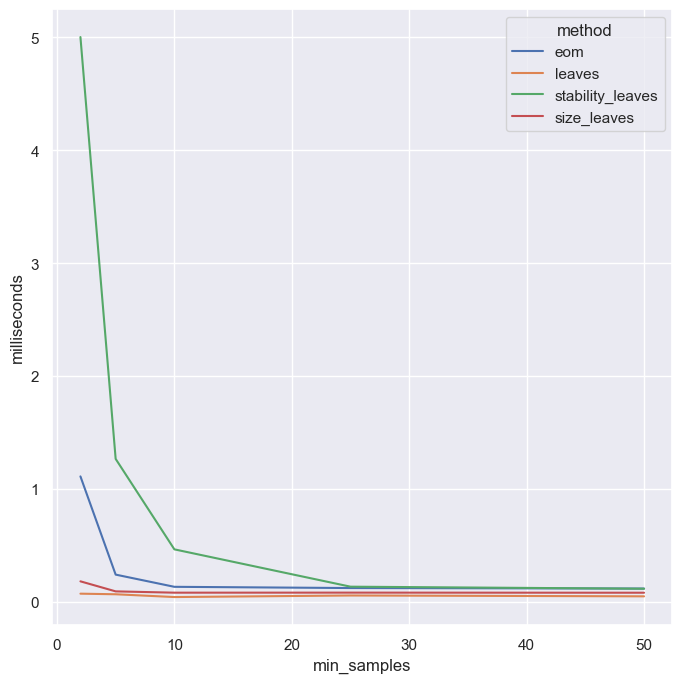

In [54]:
sns.lineplot(records, x='min_samples', y='milliseconds', hue='method')
plt.show()